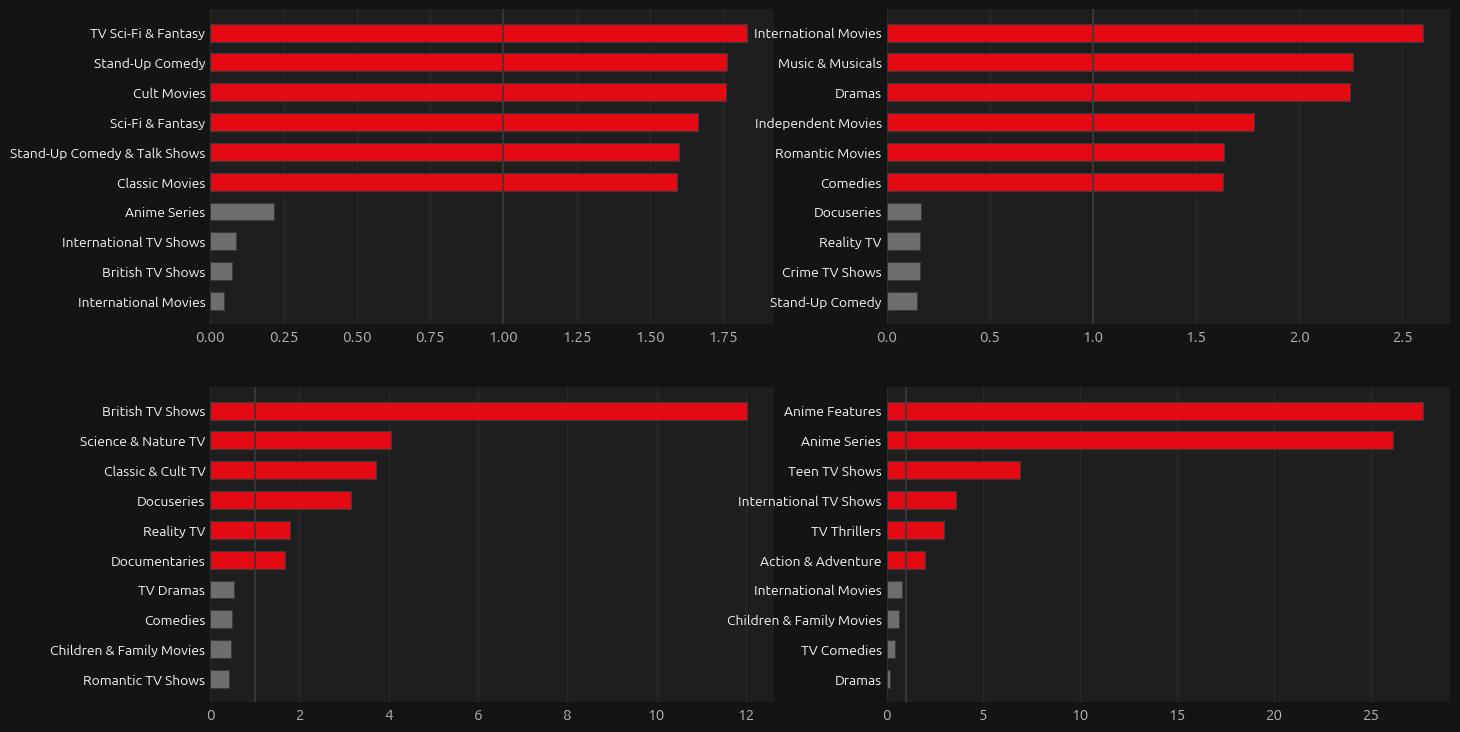

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# -----------------------------
# Config
# -----------------------------
CSV_CANDIDATES = ["../data/netflix1.csv", "data/netflix1.csv", "netflix1.csv", "/mnt/data/netflix1.csv"]
COUNTRIES = ["United States", "India", "United Kingdom", "Japan"]

TOP_POS = 6          # strongest over-indexed (highest ×global)
TOP_NEG = 4          # strongest under-indexed (lowest ×global)
MIN_COUNT = 5        # avoid noise (genre must appear at least MIN_COUNT times in the country)

USE_LOG_X = True     # log-scale is best for "×global" (e.g., 0.2× to 30×)

# Netflix-ish dark theme
BG = "#141414"
PANEL = "#1E1E1E"
GRID = "#2A2A2A"
TEXT = "#F5F5F1"
SUBTEXT = "#B3B3B3"
NETFLIX_RED = "#E50914"
NEG = "#6E6E6E"
EDGE = "#3A3A3A"

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Netflix Sans", "Helvetica Neue", "Segoe UI", "Roboto", "Ubuntu", "DejaVu Sans", "Arial"],
    "font.size": 11,
})

def split_list(val):
    if pd.isna(val):
        return []
    return [x.strip() for x in str(val).split(",") if x.strip()]

# -----------------------------
# Load data
# -----------------------------
csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(f"Could not find netflix1.csv. Tried: {CSV_CANDIDATES}")

df = pd.read_csv(csv_path)

id_col = "show_id" if "show_id" in df.columns else None
if id_col is None:
    df = df.reset_index().rename(columns={"index": "title_id"})
    id_col = "title_id"

if "country" not in df.columns or "listed_in" not in df.columns:
    raise ValueError("CSV must contain columns: country, listed_in")

# Deduplicate titles, keep multi-country + multi-genre info
base = (
    df[[id_col, "country", "listed_in"]]
    .dropna(subset=["listed_in"])
    .drop_duplicates(subset=[id_col])
    .copy()
)
base["country_list"] = base["country"].apply(split_list)
base["genre_set"] = base["listed_in"].apply(lambda x: set(split_list(x)))  # each title counts once per genre

# -----------------------------
# Global genre share (baseline)
# Each title contributes once to each genre
# -----------------------------
global_total_titles = base[id_col].nunique()

g_rows = []
for _, r in base.iterrows():
    tid = r[id_col]
    for g in r["genre_set"]:
        g_rows.append((tid, g))
g_long = pd.DataFrame(g_rows, columns=[id_col, "genre"]).drop_duplicates(subset=[id_col, "genre"])

global_counts = g_long.groupby("genre")[id_col].nunique()
global_share = (global_counts / global_total_titles).replace([np.inf], np.nan).fillna(0.0)

# -----------------------------
# Country genre share
# Build (title, country, genre) for the selected 4 countries
# -----------------------------
rows = []
for _, r in base.iterrows():
    tid = r[id_col]
    cs = r["country_list"]
    gs = r["genre_set"]
    for c in cs:
        if c in COUNTRIES:
            for g in gs:
                rows.append((tid, c, g))

long4 = pd.DataFrame(rows, columns=[id_col, "country", "genre"]).drop_duplicates(subset=[id_col, "country", "genre"])

country_totals = long4.groupby("country")[id_col].nunique().reindex(COUNTRIES)
country_genre_counts = (
    long4.groupby(["country", "genre"])[id_col]
    .nunique()
    .unstack(fill_value=0)
    .reindex(index=COUNTRIES, fill_value=0)
)
country_share = country_genre_counts.div(country_totals, axis=0).fillna(0.0)

# Align genres
all_genres = sorted(set(country_share.columns).union(set(global_share.index)))
country_share = country_share.reindex(columns=all_genres, fill_value=0.0)
country_genre_counts = country_genre_counts.reindex(columns=all_genres, fill_value=0)
global_share = global_share.reindex(all_genres).fillna(0.0)

# -----------------------------
# Index = (country share) / (global share)  -> "× global"
# handle global_share == 0 to avoid divide-by-zero
# -----------------------------
eps = 1e-12
index_x = country_share.div(global_share.clip(lower=eps), axis=1)

# -----------------------------
# Select top over/under per country
# -----------------------------
selection = {}
for c in COUNTRIES:
    counts = country_genre_counts.loc[c]
    eligible = counts[counts >= MIN_COUNT].index

    s = index_x.loc[c, eligible].replace([np.inf], np.nan).dropna()
    s = s[s > 0]  # ignore zeros
    s_sorted = s.sort_values(ascending=False)

    # fallback if too strict
    if len(s_sorted) < (TOP_POS + TOP_NEG):
        eligible = counts[counts >= 1].index
        s = index_x.loc[c, eligible].replace([np.inf], np.nan).dropna()
        s = s[s > 0]
        s_sorted = s.sort_values(ascending=False)

    sel = pd.concat([s_sorted.head(TOP_POS), s_sorted.tail(TOP_NEG)]).sort_values()
    selection[c] = sel

# -----------------------------
# Plot 2x2 (black Netflix style)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 9), facecolor=BG)
axes = axes.flatten()

def style_ax(ax):
    ax.set_facecolor(PANEL)
    ax.grid(axis="x", color=GRID, linewidth=0.9)
    ax.set_axisbelow(True)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.tick_params(colors=SUBTEXT, length=0)

def fmt_x(v, _):
    if v >= 10:
        return f"{v:.0f}×"
    if v >= 1:
        return f"{v:.1f}×"
    return f"{v:.2f}×"

for ax, c in zip(axes, COUNTRIES):
    style_ax(ax)
    s = selection[c]
    y = np.arange(len(s))

    # color by above/below 1×
    colors = [NETFLIX_RED if v >= 1 else NEG for v in s.values]
    ax.barh(y, s.values, color=colors, edgecolor=EDGE, linewidth=0.8, height=0.60)

    ax.set_yticks(y)
    ax.set_yticklabels(s.index, color=TEXT, fontsize=10)

    # baseline at 1× global
    ax.axvline(1, color=EDGE, linewidth=1.2)

    if USE_LOG_X:
        ax


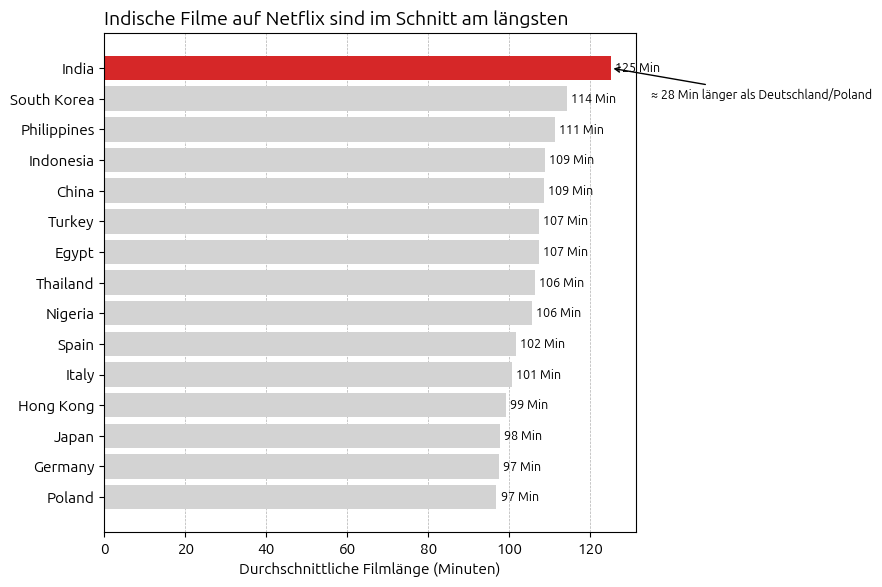

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden
df = pd.read_csv("../data/netflix1.csv")

# Nur Filme
movies = df[df["type"] == "Movie"].copy()

# Dauer in Minuten als Zahl
movies["duration_min"] = (
    movies["duration"]
    .str.replace(" min", "", regex=False)
    .astype(float)
)

# Länder aufsplitten (falls mehrere)
movies = movies.dropna(subset=["duration_min", "country"])
movies["country"] = movies["country"].str.split(",")
movies = movies.explode("country")
movies["country"] = movies["country"].str.strip()

# Kennzahlen pro Land
country_stats = (
    movies.groupby("country")
    .agg(avg_duration=("duration_min", "mean"),
         count=("duration_min", "size"))
    .reset_index()
)

# Nur Länder mit genügend Filmen
min_movies = 20
country_stats = country_stats[country_stats["count"] >= min_movies]

# Sortieren, Top 15
top_countries = (
    country_stats
    .sort_values("avg_duration", ascending=False)
    .head(15)
)

# ----------------------------
# STORYTELLING PLOT
# ----------------------------

countries = top_countries["country"]
values = top_countries["avg_duration"]

highlight_country = "India"  # Land, das du hervorheben willst

colors = [
    "tab:red" if c == highlight_country else "lightgrey"
    for c in countries
]

fig, ax = plt.subplots(figsize=(9, 6))

# Horizontaler Balken-Plot
ax.barh(countries, values, color=colors)

# Längstes oben
ax.invert_yaxis()

# Titel & Untertitel (Story!)
ax.set_title(
    "Indische Filme auf Netflix sind im Schnitt am längsten",
    loc="left", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Durchschnittliche Filmlänge (Minuten)")

# Werte an die Balken schreiben
for i, (country, val) in enumerate(zip(countries, values)):
    ax.text(
        val + 1, i, f"{val:.0f} Min",
        va="center", fontsize=9
    )

# Kleine Text-Anmerkung
india_val = top_countries[top_countries["country"] == "India"]["avg_duration"].iloc[0]
ger_val = top_countries[top_countries["country"] == "Germany"]["avg_duration"].iloc[0] \
          if "Germany" in list(top_countries["country"]) else None

if ger_val is not None:
    diff = india_val - ger_val
    ax.annotate(
        f"≈ {diff:.0f} Min länger als Deutschland/Poland",
        xy=(india_val, 0),
        xytext=(india_val + 10, 1),
        arrowprops=dict(arrowstyle="->", linewidth=1),
        fontsize=9
    )

# Gitterlinien dezent auf der x-Achse
ax.xaxis.grid(True, linestyle="--", linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


### Kernaussage der Grafik

- **Indien** hat mit durchschnittlich **≈125 Minuten** die **längsten Filme** im Datensatz.  
  - Tradition des „vollständigen Pakets“: lange Handlungen, mehrere Storylines, Musik- und Tanzszenen.  
  - Publikum ist lange Laufzeiten gewohnt – Filme sind als großes Kino-Erlebnis gedacht.

- Länder wie **Südkorea, Philippinen, Indonesien, China, Türkei, Ägypten**  
  - Ebenfalls oft **über 105 Minuten**.  
  - Häufig kinotypische, dramatische Filme mit mehr Zeit für Figuren und Plot.

- **Polen, Deutschland, Japan** liegen mit **ca. 97–100 Minuten** am unteren Ende unserer Auswahl.  
  - Starke Orientierung am klassischen **90-Minuten-Format** (Drama, Thriller, Komödie).  
  - Tendenziell straffer, fokussierter erzählt, weniger „epische“ Struktur.

- **Wichtiger Hinweis:**  
  - Grundlage ist **nur der Netflix-Datensatz** (nur Filme, nur Länder mit ≥20 Titeln).  
  - Trotzdem zeigt sich klar:  
    **Je nach Produktionsland unterscheiden sich typische Filmlängen deutlich – Indien sticht dabei als „Langfilm-Champion“ heraus.**


### Kernaussage der Grafik

- **Indien** hat mit durchschnittlich **≈125 Minuten** die **längsten Filme** im Datensatz.  
  - Tradition des „vollständigen Pakets“: lange Handlungen, mehrere Storylines, Musik- und Tanzszenen.  
  - Publikum ist lange Laufzeiten gewohnt – Filme sind als großes Kino-Erlebnis gedacht.
  - Bollywood

- Länder wie **Südkorea, Philippinen, Indonesien, China, Türkei, Ägypten**  
  - Ebenfalls oft **über 105 Minuten**.  
  - Häufig kinotypische, dramatische Filme mit mehr Zeit für Figuren und Plot.

- **Polen, Deutschland, Japan** liegen mit **ca. 97–100 Minuten** am unteren Ende unserer Auswahl.  
  - Starke Orientierung am klassischen **90-Minuten-Format** (Drama, Thriller, Komödie).  
  - Tendenziell straffer, fokussierter erzählt, weniger „epische“ Struktur.

- **Wichtiger Hinweis:**  
  - Grundlage ist **nur der Netflix-Datensatz** (nur Filme, nur Länder mit ≥20 Titeln).  
  - Trotzdem zeigt sich klar:  
    **Je nach Produktionsland unterscheiden sich typische Filmlängen deutlich – Indien sticht dabei als „Langfilm-Champion“ heraus.**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden
df = pd.read_csv("../data/netflix1.csv")

# Nur Filme
movies = df[df["type"] == "Movie"].copy()

# Dauer in Minuten als Zahl
movies["duration_min"] = (
    movies["duration"]
    .str.replace(" min", "", regex=False)
    .astype(float)
)

# Nur Zeilen mit Land und Dauer
movies = movies.dropna(subset=["duration_min", "country"])

# Länder aufsplitten (falls mehrere angegeben sind)
movies["country"] = movies["country"].str.split(",")
movies = movies.explode("country")
movies["country"] = movies["country"].str.strip()


<Figure size 1000x600 with 0 Axes>

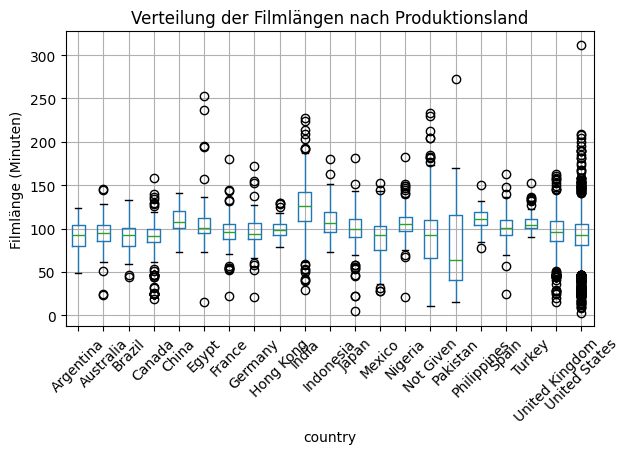

In [7]:
# Länder mit genug Filmen auswählen (z.B. >= 50 Filme)
top_countries = (
    movies["country"].value_counts()
    .loc[lambda s: s >= 50]
    .index
)

subset = movies[movies["country"].isin(top_countries)]

plt.figure(figsize=(10, 6))
subset.boxplot(column="duration_min", by="country", rot=45)
plt.suptitle("")  # Standard-Überschrift von pandas entfernen
plt.title("Verteilung der Filmlängen nach Produktionsland")
plt.ylabel("Filmlänge (Minuten)")
plt.tight_layout()
plt.show()


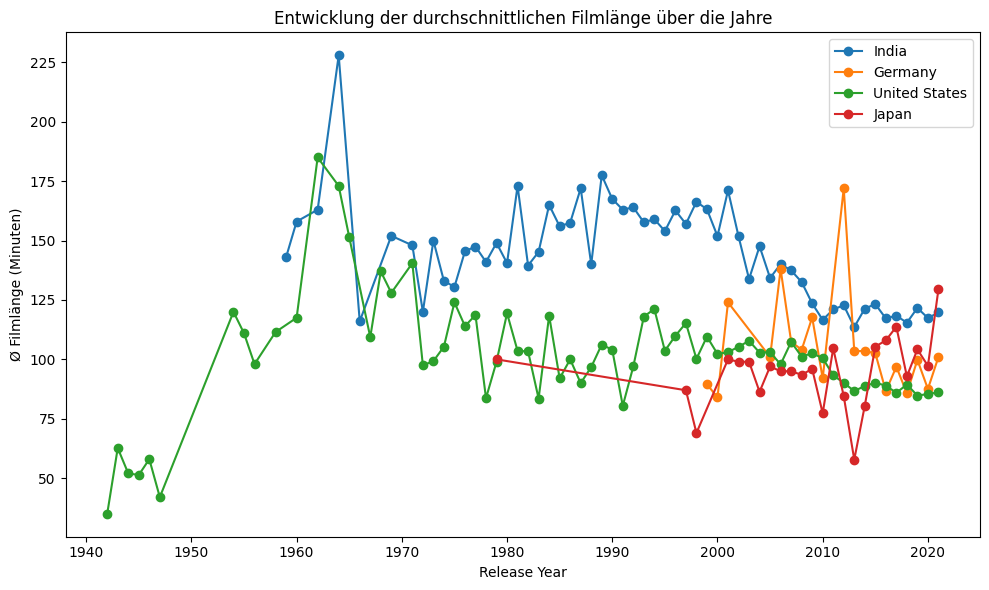

In [5]:
# Länder, die dich interessieren
countries_of_interest = ["India", "Germany", "United States", "Japan"]

trend = (
    movies[movies["country"].isin(countries_of_interest)]
    .groupby(["release_year", "country"])["duration_min"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))

for c in countries_of_interest:
    sub = trend[trend["country"] == c]
    plt.plot(sub["release_year"], sub["duration_min"], marker="o", label=c)

plt.xlabel("Release Year")
plt.ylabel("Ø Filmlänge (Minuten)")
plt.title("Entwicklung der durchschnittlichen Filmlänge über die Jahre")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
movies_genre = movies.copy()
movies_genre["main_genre"] = (
    movies_genre["listed_in"]
    .str.split(",")
    .str[0]
    .str.strip()
)

# Durchschnittliche Dauer pro Land und Hauptgenre
genre_country = (
    movies_genre
    .groupby(["country", "main_genre"])
    .agg(
        avg_duration=("duration_min", "mean"),
        n=("duration_min", "size")
    )
    .reset_index()
)

# Beispiel: Die längsten Dramen (nur Länder mit >= 20 Drama-Filmen)
drama = genre_country[
    (genre_country["main_genre"] == "Dramas") &
    (genre_country["n"] >= 20)
].sort_values("avg_duration", ascending=False)

print(drama.head(10))


            country main_genre  avg_duration    n
135           India     Dramas    125.041565  409
257     Philippines     Dramas    112.722222   36
144       Indonesia     Dramas    111.148936   47
310           Spain     Dramas    110.976190   42
219         Nigeria     Dramas    110.340426   47
343          Turkey     Dramas    109.500000   20
110         Germany     Dramas    107.956522   23
356  United Kingdom     Dramas    107.910000  100
373   United States     Dramas    106.055427  433
98           France     Dramas    105.452830   53


In [9]:
stats = (
    movies.groupby("country")["duration_min"]
    .agg(
        mean="mean",
        median="median",
        std="std",
        count="size"
    )
)

# Nur Länder mit genügend Filmen
stats = stats[stats["count"] >= 20]

# Länder mit der größten Streuung
print(stats.sort_values("std", ascending=False).head(10))


                      mean  median        std  count
country                                             
Pakistan         76.633803    64.0  46.679527     71
Not Given        92.517510    92.0  38.417737    257
Netherlands      92.086957    88.0  33.220904     23
Italy           100.638298    99.0  28.503566     47
Egypt           107.449541   101.0  27.877206    109
Japan            97.620690    99.0  27.290104     87
India           125.065574   126.0  26.873909    976
United Kingdom   94.720930    96.0  25.788491    387
United States    91.782463    93.0  25.538426   2395
Mexico           89.100000    92.0  25.165542     90


In [10]:
rating_stats = (
    movies.groupby(["country", "rating"])["duration_min"]
    .agg(avg_duration="mean", n="size")
    .reset_index()
)

# Beispiel: nur ausgewählte Länder ansehen
focus_countries = ["India", "Germany", "United States"]
subset = rating_stats[
    rating_stats["country"].isin(focus_countries)
].sort_values(["country", "avg_duration"], ascending=[True, False])

print(subset.head(30))


           country    rating  avg_duration    n
105        Germany         R    120.846154   13
102        Germany        NR    116.000000    1
109        Germany     TV-PG     98.400000    5
104        Germany     PG-13     97.571429    7
103        Germany        PG     96.250000    4
106        Germany     TV-14     95.333333   12
108        Germany     TV-MA     93.766667   30
111        Germany     TV-Y7     93.000000    1
110        Germany      TV-Y     83.000000    1
101        Germany         G     79.000000    1
107        Germany      TV-G     60.500000    4
131          India         R    147.500000    2
129          India        PG    145.750000    4
130          India     PG-13    134.400000    5
132          India     TV-14    131.029091  550
135          India     TV-PG    126.469231  130
134          India     TV-MA    118.771552  232
133          India      TV-G    118.500000    6
128          India        NR    110.000000    4
138          India  TV-Y7-FV    109.0000

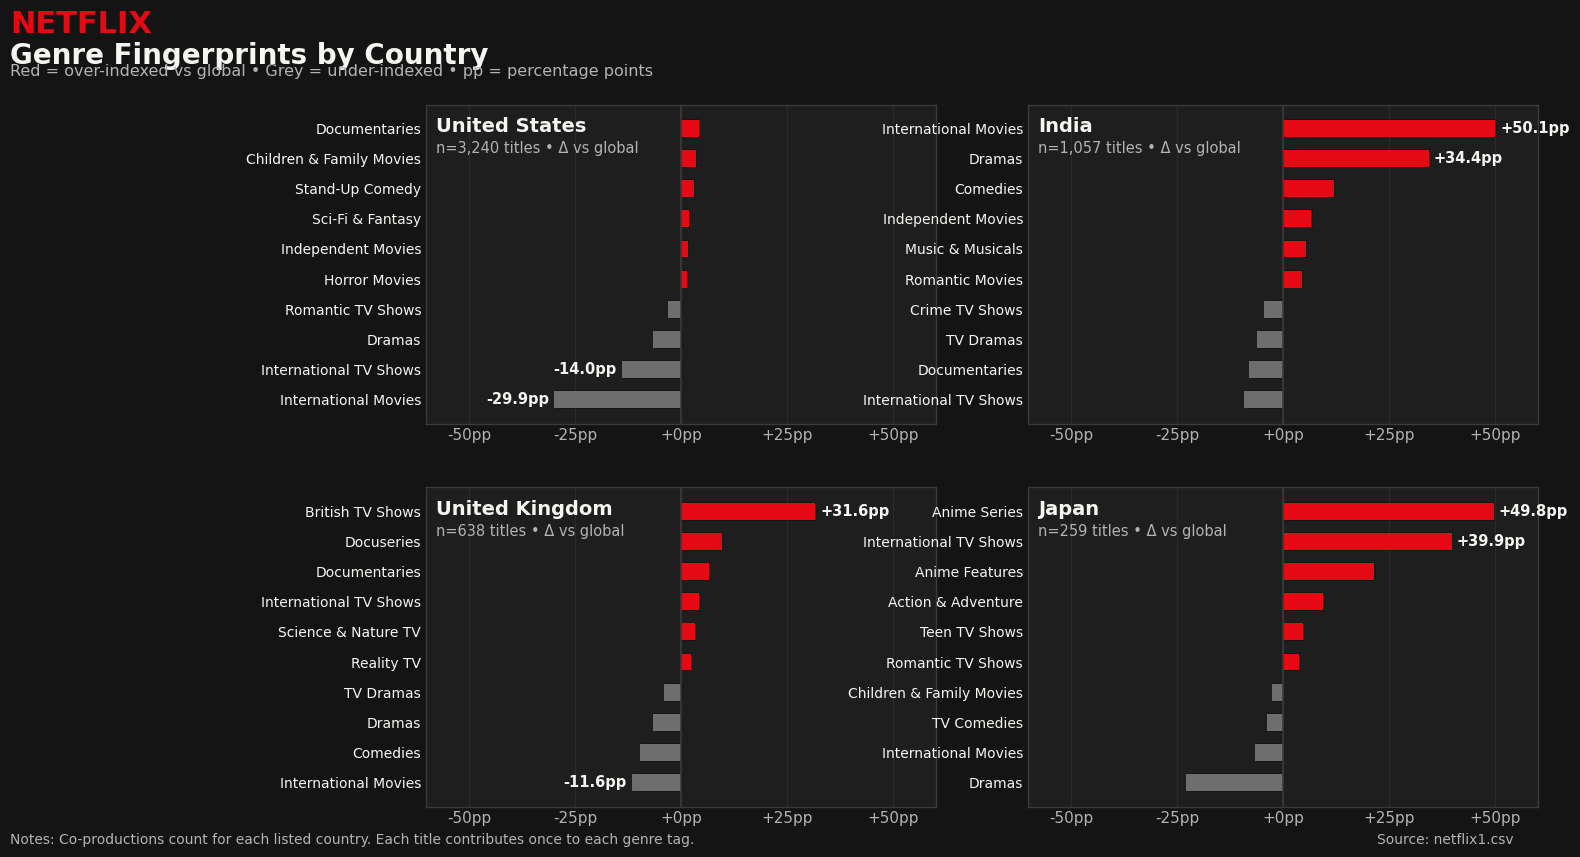

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- Paths & settings ---
CSV_CANDIDATES = ["../data/netflix1.csv", "netflix1.csv", "/mnt/data/netflix1.csv"]
COUNTRIES = ["United States", "India", "United Kingdom", "Japan"]

TOP_POS, TOP_NEG, MIN_COUNT = 6, 4, 5

# Netflix-ish colors
BG = "#141414"
PANEL = "#1E1E1E"
GRID = "#2A2A2A"
TEXT = "#F5F5F1"
SUBTEXT = "#B3B3B3"
NETFLIX_RED = "#E50914"
NEG = "#6E6E6E"
AXIS = "#3A3A3A"

# --- Load CSV ---
csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("Could not find netflix1.csv (tried ../data/, current folder, /mnt/data/).")

df = pd.read_csv(csv_path)

id_col = "show_id" if "show_id" in df.columns else None
if id_col is None:
    df = df.reset_index().rename(columns={"index": "title_id"})
    id_col = "title_id"

if "country" not in df.columns or "listed_in" not in df.columns:
    raise ValueError("CSV must contain columns: country, listed_in")

def split_list(x):
    if pd.isna(x):
        return []
    return [t.strip() for t in str(x).split(",") if t.strip()]

# Dedup titles
base = df[[id_col, "country", "listed_in"]].dropna(subset=["listed_in"]).drop_duplicates(subset=[id_col]).copy()
base["country_list"] = base["country"].apply(split_list)
base["genre_set"] = base["listed_in"].apply(lambda x: set(split_list(x)))

# Build (title,country,genre) rows (only the 4 countries)
rows = []
for _, r in base.iterrows():
    cs, gs = r["country_list"], r["genre_set"]
    if not cs or not gs:
        continue
    tid = r[id_col]
    for c in cs:
        if c in COUNTRIES:
            for g in gs:
                rows.append((tid, c, g))

long4 = pd.DataFrame(rows, columns=[id_col, "country", "genre"]).drop_duplicates()

# Global share (each title contributes once per genre)
global_total_titles = base[id_col].nunique()
g_rows = []
for _, r in base.iterrows():
    tid = r[id_col]
    for g in r["genre_set"]:
        g_rows.append((tid, g))
g_long = pd.DataFrame(g_rows, columns=[id_col, "genre"]).drop_duplicates()
global_share = g_long.groupby("genre")[id_col].nunique() / global_total_titles

# Country share
country_totals = long4.groupby("country")[id_col].nunique().reindex(COUNTRIES)
country_genre_counts = (
    long4.groupby(["country", "genre"])[id_col].nunique()
    .unstack(fill_value=0)
    .reindex(index=COUNTRIES, fill_value=0)
)
country_share = country_genre_counts.div(country_totals, axis=0)

# Align
all_genres = sorted(set(country_share.columns).union(set(global_share.index)))
country_genre_counts = country_genre_counts.reindex(columns=all_genres, fill_value=0)
country_share = country_share.reindex(columns=all_genres, fill_value=0.0)
global_share = global_share.reindex(all_genres).fillna(0.0)

delta_pp = (country_share - global_share) * 100.0

# Select per country: TOP_POS over-index + TOP_NEG under-index (min count filter)
selection = {}
for c in COUNTRIES:
    counts = country_genre_counts.loc[c]
    eligible = counts[counts >= MIN_COUNT].index
    s = delta_pp.loc[c, eligible].dropna().sort_values(ascending=False)
    if len(s) < (TOP_POS + TOP_NEG):
        eligible = counts[counts >= 1].index
        s = delta_pp.loc[c, eligible].dropna().sort_values(ascending=False)
    sel = pd.concat([s.head(TOP_POS), s.tail(TOP_NEG)])
    selection[c] = sel.sort_values()  # barh: bottom->top

max_abs = max(float(np.nanmax(np.abs(selection[c].values))) for c in COUNTRIES)
lim = min(80, max(10, max_abs * 1.2))

# --- Plot ---
plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(2, 2, figsize=(16, 9), facecolor=BG)
axes = axes.flatten()

def style_ax(ax):
    ax.set_facecolor(PANEL)
    for sp in ax.spines.values():
        sp.set_color(AXIS)
        sp.set_linewidth(1.0)
    ax.tick_params(colors=SUBTEXT, labelcolor=SUBTEXT, length=0)
    ax.grid(axis="x", color=GRID, linewidth=0.9)
    ax.set_axisbelow(True)

for ax, c in zip(axes, COUNTRIES):
    style_ax(ax)
    s = selection[c]
    y = np.arange(len(s))
    vals = s.values

    colors = [NETFLIX_RED if v > 0 else NEG for v in vals]
    # shadow then main bars (subtle depth)
    ax.barh(y, vals, color="#000000", alpha=0.25, height=0.62, left=0.35, zorder=1)
    ax.barh(y, vals, color=colors, height=0.56, zorder=2)

    ax.axvline(0, color=AXIS, linewidth=1.2)

    ax.set_yticks(y)
    ax.set_yticklabels(s.index, color=TEXT, fontsize=10)

    ax.set_xlim(-lim, lim)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(5, integer=True))
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: f"{v:+.0f}pp"))
    ax.tick_params(axis="x", colors=SUBTEXT)

    # Panel header
    n_titles = int(country_totals.loc[c]) if pd.notna(country_totals.loc[c]) else 0
    ax.text(0.02, 0.96, c, transform=ax.transAxes, ha="left", va="top",
            fontsize=14, fontweight="bold", color=TEXT)
    ax.text(0.02, 0.885, f"n={n_titles:,} titles • Δ vs global", transform=ax.transAxes,
            ha="left", va="top", fontsize=10.5, color=SUBTEXT)

    # annotate strongest two deltas for readability
    idx = np.argsort(np.abs(vals))[-2:]
    for i in idx:
        v = float(vals[i])
        ax.text(v + (1.2 if v >= 0 else -1.2), y[i], f"{v:+.1f}pp",
                va="center", ha="left" if v >= 0 else "right",
                fontsize=10.5, color=TEXT, fontweight="bold")

# Title block
fig.text(0.03, 0.965, "NETFLIX", color=NETFLIX_RED, fontsize=22, fontweight="bold", ha="left", va="top")
fig.text(0.03, 0.93, "Genre Fingerprints by Country", color=TEXT, fontsize=20, fontweight="bold", ha="left", va="top")
fig.text(0.03, 0.905, "Red = over-indexed vs global • Grey = under-indexed • pp = percentage points",
         color=SUBTEXT, fontsize=11.5, ha="left", va="top")

# Footer
fig.text(0.03, 0.035,
         "Notes: Co-productions count for each listed country. Each title contributes once to each genre tag.",
         color=SUBTEXT, fontsize=10, ha="left", va="bottom")
fig.text(0.97, 0.035, f"Source: {os.path.basename(csv_path)}",
         color=SUBTEXT, fontsize=10, ha="right", va="bottom")

plt.subplots_adjust(left=0.29, right=0.985, top=0.86, bottom=0.08, wspace=0.18, hspace=0.20)

out_png = "netflix_genre_fingerprints_modern.png"
out_pdf = "netflix_genre_fingerprints_modern.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor=BG)
plt.savefig(out_pdf, bbox_inches="tight", facecolor=BG)
plt.show()


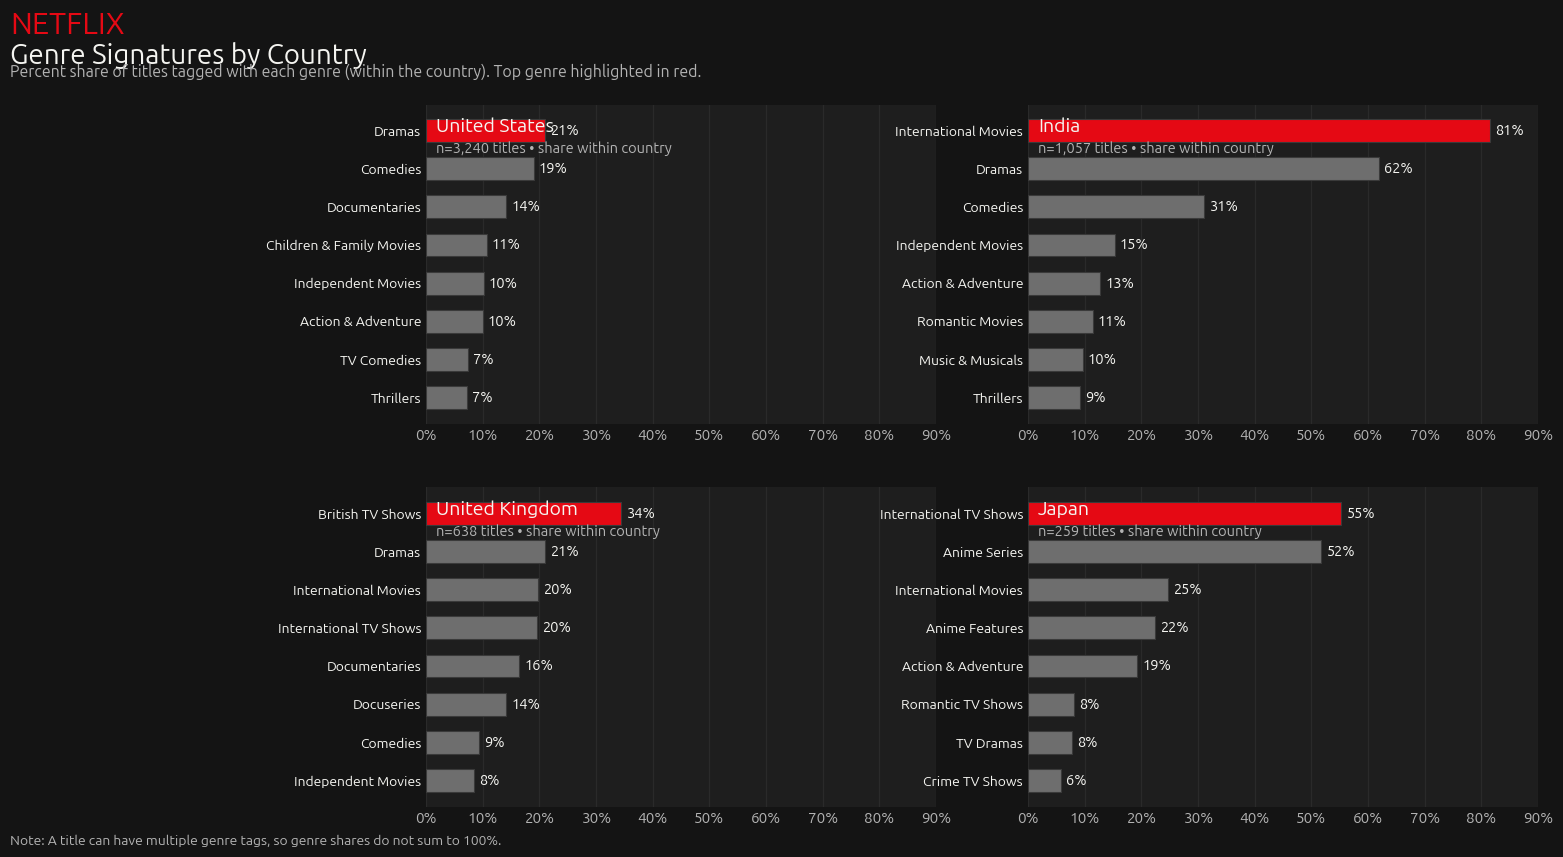

Saved: netflix_genre_signatures_percent_2x2.png


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# -----------------------------
# Config
# -----------------------------
CSV_CANDIDATES = ["../data/netflix1.csv", "data/netflix1.csv", "netflix1.csv", "/mnt/data/netflix1.csv"]
COUNTRIES = ["United States", "India", "United Kingdom", "Japan"]

TOP_N = 8          # Top Genres pro Land (als “Signature”)
MIN_COUNT = 5      # Noise-Filter: Genre muss mind. so oft im Land vorkommen

# Netflix-ish style
BG = "#141414"
PANEL = "#1E1E1E"
GRID = "#2A2A2A"
TEXT = "#F5F5F1"
SUBTEXT = "#B3B3B3"
NETFLIX_RED = "#E50914"
NEG = "#6E6E6E"
EDGE = "#3A3A3A"

# Font stack (falls Netflix Sans nicht installiert ist, wird automatisch gefallbackt)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Netflix Sans", "Helvetica Neue", "Segoe UI", "Roboto", "Ubuntu", "DejaVu Sans", "Arial"],
    "font.size": 11,
})

# -----------------------------
# Load data
# -----------------------------
csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(f"Could not find netflix1.csv. Tried: {CSV_CANDIDATES}")

df = pd.read_csv(csv_path)

# Stable id
id_col = "show_id" if "show_id" in df.columns else None
if id_col is None:
    df = df.reset_index().rename(columns={"index": "title_id"})
    id_col = "title_id"

required = {"country", "listed_in"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Found: {list(df.columns)}")

def split_list(val):
    if pd.isna(val):
        return []
    return [x.strip() for x in str(val).split(",") if x.strip()]

# Deduplicate titles
base = (
    df[[id_col, "country", "listed_in"]]
    .dropna(subset=["listed_in"])
    .drop_duplicates(subset=[id_col])
    .copy()
)
base["country_list"] = base["country"].apply(split_list)
base["genre_set"] = base["listed_in"].apply(lambda x: set(split_list(x)))  # avoid double-count per title

# -----------------------------
# Build long table (title, country, genre)
# -----------------------------
rows = []
for _, r in base.iterrows():
    cs = r["country_list"]
    gs = r["genre_set"]
    if not cs or not gs:
        continue
    tid = r[id_col]
    for c in cs:
        if c in COUNTRIES:
            for g in gs:
                rows.append((tid, c, g))

long4 = pd.DataFrame(rows, columns=[id_col, "country", "genre"]).drop_duplicates()

# Country totals (unique titles per country)
country_totals = long4.groupby("country")[id_col].nunique().reindex(COUNTRIES)

# Genre counts per country (unique titles tagged with genre)
country_genre_counts = (
    long4.groupby(["country", "genre"])[id_col]
    .nunique()
    .unstack(fill_value=0)
    .reindex(index=COUNTRIES, fill_value=0)
)

# Share (%) within each country
country_genre_share = country_genre_counts.div(country_totals, axis=0)

# Select TOP_N per country (apply MIN_COUNT noise filter)
selection = {}
for c in COUNTRIES:
    counts = country_genre_counts.loc[c]
    eligible = counts[counts >= MIN_COUNT].index
    s = country_genre_share.loc[c, eligible].dropna().sort_values(ascending=False)

    if len(s) < TOP_N:  # fallback if filter is too strict
        eligible = counts[counts >= 1].index
        s = country_genre_share.loc[c, eligible].dropna().sort_values(ascending=False)

    selection[c] = s.head(TOP_N).sort_values()  # barh: bottom->top

# Consistent x-limit (across all panels)
max_share = max(float(selection[c].max()) for c in COUNTRIES if len(selection[c]) > 0)
xlim = min(0.90, max_share * 1.20)  # cap for aesthetics

# -----------------------------
# Plot: 2×2 “Genre Signatures” (percent, no minus/pp)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 9), facecolor=BG)
axes = axes.flatten()

def style_ax(ax):
    ax.set_facecolor(PANEL)
    ax.grid(axis="x", color=GRID, linewidth=0.9)
    ax.set_axisbelow(True)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.tick_params(colors=SUBTEXT, length=0)

for ax, c in zip(axes, COUNTRIES):
    style_ax(ax)

    s = selection[c]  # index=genre, values=share (0..1)
    y = np.arange(len(s))

    # color: top genre red, rest grey (clean signature)
    colors = [NETFLIX_RED if i == len(s) - 1 else NEG for i in range(len(s))]

    ax.barh(y, s.values, color=colors, edgecolor=EDGE, linewidth=0.8, height=0.60)
    ax.set_yticks(y)
    ax.set_yticklabels(s.index, color=TEXT, fontsize=10)

    ax.set_xlim(0, xlim)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    ax.tick_params(axis="x", colors=SUBTEXT)

    n_titles = int(country_totals.loc[c]) if pd.notna(country_totals.loc[c]) else 0
    ax.text(0.02, 0.96, c, transform=ax.transAxes, ha="left", va="top",
            fontsize=14, fontweight="bold", color=TEXT)
    ax.text(0.02, 0.885, f"n={n_titles:,} titles • share within country",
            transform=ax.transAxes, ha="left", va="top", fontsize=10.5, color=SUBTEXT)

    # value labels
    for yi, v in zip(y, s.values):
        ax.text(v + xlim*0.01, yi, f"{v*100:.0f}%", va="center", ha="left",
                fontsize=10.5, color=TEXT, fontweight="bold")

# Title block
fig.text(0.03, 0.965, "NETFLIX", color=NETFLIX_RED, fontsize=22, fontweight="bold", ha="left", va="top")
fig.text(0.03, 0.93, "Genre Signatures by Country", color=TEXT, fontsize=20, fontweight="bold", ha="left", va="top")
fig.text(0.03, 0.905,
         "Percent share of titles tagged with each genre (within the country). Top genre highlighted in red.",
         color=SUBTEXT, fontsize=11.5, ha="left", va="top")

fig.text(0.03, 0.035,
         "Note: A title can have multiple genre tags, so genre shares do not sum to 100%.",
         color=SUBTEXT, fontsize=10, ha="left", va="bottom")

plt.subplots_adjust(left=0.29, right=0.985, top=0.86, bottom=0.08, wspace=0.18, hspace=0.20)

out_png = "netflix_genre_signatures_percent_2x2.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor=BG)
plt.show()

print(f"Saved: {out_png}")
